In [1]:
# Core Libraries for PCA Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, load_wine, make_classification, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [2]:
# PCA Analysis Functions
def create_pca_datasets():
    """Create various datasets for PCA demonstration"""
    datasets = {}
    
    # Dataset 1: Wine dataset (13 features)
    wine = load_wine()
    datasets['wine'] = (wine.data, wine.target, wine.feature_names, wine.target_names)
    
    # Dataset 2: Digits dataset (64 features - 8x8 pixel images)
    digits = load_digits()
    datasets['digits'] = (digits.data, digits.target, [f'pixel_{i}' for i in range(64)], digits.target_names)
    
    # Dataset 3: Breast cancer dataset (30 features)
    cancer = load_breast_cancer()
    datasets['breast_cancer'] = (cancer.data, cancer.target, cancer.feature_names, cancer.target_names)
    
    # Dataset 4: Synthetic high-dimensional dataset
    X_synthetic, y_synthetic = make_classification(
        n_samples=1000, n_features=50, n_informative=10, n_redundant=10,
        n_clusters_per_class=2, random_state=42
    )
    feature_names_synthetic = [f'feature_{i}' for i in range(50)]
    target_names_synthetic  = ['Class_0', 'Class_1']
    datasets['synthetic']   = (X_synthetic, y_synthetic, feature_names_synthetic, target_names_synthetic)
    
    return datasets

def analyze_pca_components(pca_model, feature_names=None, n_top_features=5):
    """
    Analyze PCA components and their feature contributions
    
    Parameters:
    -----------
    pca_model : PCA
        Fitted PCA model
    feature_names : list, optional
        Names of original features
    n_top_features : int
        Number of top contributing features to show per component
    
    Returns:
    --------
    component_analysis : dict
        Analysis results for each component
    """
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(pca_model.n_features_)]
    
    component_analysis = {}
    
    for i, component in enumerate(pca_model.components_):
        # Get absolute loadings for ranking
        abs_loadings = np.abs(component)
        
        # Get top contributing features
        top_indices = np.argsort(abs_loadings)[-n_top_features:][::-1]
        
        component_info = {
            'explained_variance_ratio': pca_model.explained_variance_ratio_[i],
            'explained_variance': pca_model.explained_variance_[i],
            'top_features': [
                {
                    'feature': feature_names[idx],
                    'loading': component[idx],
                    'abs_loading': abs_loadings[idx]
                }
                for idx in top_indices
            ],
            'all_loadings': dict(zip(feature_names, component))
        }
        
        component_analysis[f'PC{i+1}'] = component_info
    
    return component_analysis

def plot_pca_analysis(X_original, X_pca, y, pca_model, feature_names=None, target_names=None, figsize=(16, 12)):
    """
    Comprehensive PCA visualization
    
    Parameters:
    -----------
    X_original : array-like
        Original data
    X_pca : array-like
        PCA-transformed data
    y : array-like
        Target labels
    pca_model : PCA
        Fitted PCA model
    feature_names : list, optional
        Original feature names
    target_names : list, optional
        Target class names
    figsize : tuple
        Figure size
    """
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    # 1. Explained Variance Ratio
    axes[0, 0].bar(range(1, len(pca_model.explained_variance_ratio_) + 1), pca_model.explained_variance_ratio_)
    axes[0, 0].set_title('Explained Variance Ratio by Component')
    axes[0, 0].set_xlabel('Principal Component')
    axes[0, 0].set_ylabel('Explained Variance Ratio')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Cumulative Explained Variance
    cumsum_var = np.cumsum(pca_model.explained_variance_ratio_)
    axes[0, 1].plot(range(1, len(cumsum_var) + 1), cumsum_var, 'bo-')
    axes[0, 1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    axes[0, 1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
    axes[0, 1].set_title('Cumulative Explained Variance')
    axes[0, 1].set_xlabel('Number of Components')
    axes[0, 1].set_ylabel('Cumulative Explained Variance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. PC1 vs PC2 Scatter Plot
    if X_pca.shape[1] >= 2:
        if target_names is not None:
            for i, target_name in enumerate(target_names):
                mask = y == i
                axes[0, 2].scatter(X_pca[mask, 0], X_pca[mask, 1], label=target_name, alpha=0.7, s=30)
        else:
            scatter = axes[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7, s=30)
            plt.colorbar(scatter, ax=axes[0, 2])
        
        axes[0, 2].set_title('First Two Principal Components')
        axes[0, 2].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%} variance)')
        axes[0, 2].set_ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%} variance)')
        if target_names is not None:
            axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Component Loadings Heatmap (first 6 components, top features)
    if feature_names is not None and len(feature_names) <= 50:
        n_components_show = min(6, pca_model.n_components_)
        n_features_show = min(20, len(feature_names))
        
        # Get top features by total absolute loading across components
        total_loadings = np.sum(np.abs(pca_model.components_[:n_components_show]), axis=0)
        top_feature_indices = np.argsort(total_loadings)[-n_features_show:]
        
        loadings_subset = pca_model.components_[:n_components_show, top_feature_indices]
        feature_names_subset = [feature_names[i] for i in top_feature_indices]
        
        im = axes[1, 0].imshow(loadings_subset, cmap='RdBu_r', aspect='auto')
        axes[1, 0].set_title('Component Loadings (Top Features)')
        axes[1, 0].set_xlabel('Features')
        axes[1, 0].set_ylabel('Principal Components')
        axes[1, 0].set_xticks(range(len(feature_names_subset)))
        axes[1, 0].set_xticklabels(feature_names_subset, rotation=45, ha='right')
        axes[1, 0].set_yticks(range(n_components_show))
        axes[1, 0].set_yticklabels([f'PC{i+1}' for i in range(n_components_show)])
        plt.colorbar(im, ax=axes[1, 0])
    else:
        axes[1, 0].text(0.5, 0.5, 'Too many features\\nfor heatmap display', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Component Loadings (N/A)')
    
    # 5. PC1 vs PC3 (if available)
    if X_pca.shape[1] >= 3:
        if target_names is not None:
            for i, target_name in enumerate(target_names):
                mask = y == i
                axes[1, 1].scatter(X_pca[mask, 0], X_pca[mask, 2], label=target_name, alpha=0.7, s=30)
        else:
            scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap='tab10', alpha=0.7, s=30)
        
        axes[1, 1].set_title('PC1 vs PC3')
        axes[1, 1].set_xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.2%} variance)')
        axes[1, 1].set_ylabel(f'PC3 ({pca_model.explained_variance_ratio_[2]:.2%} variance)')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'PC3 not available', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('PC1 vs PC3 (N/A)')
    
    # 6. PC2 vs PC3 (if available)
    if X_pca.shape[1] >= 3:
        if target_names is not None:
            for i, target_name in enumerate(target_names):
                mask = y == i
                axes[1, 2].scatter(X_pca[mask, 1], X_pca[mask, 2], label=target_name, alpha=0.7, s=30)
        else:
            scatter = axes[1, 2].scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='tab10', alpha=0.7, s=30)
        
        axes[1, 2].set_title('PC2 vs PC3')
        axes[1, 2].set_xlabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.2%} variance)')
        axes[1, 2].set_ylabel(f'PC3 ({pca_model.explained_variance_ratio_[2]:.2%} variance)')
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'PC3 not available', ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('PC2 vs PC3 (N/A)')
    
    # 7. Feature Importance in PC1
    if feature_names is not None and len(feature_names) <= 30:
        pc1_loadings = pca_model.components_[0]
        sorted_indices = np.argsort(np.abs(pc1_loadings))[-15:]  # Top 15 features
        
        axes[2, 0].barh(range(len(sorted_indices)), pc1_loadings[sorted_indices])
        axes[2, 0].set_title('Feature Contributions to PC1')
        axes[2, 0].set_xlabel('Loading Score')
        axes[2, 0].set_yticks(range(len(sorted_indices)))
        axes[2, 0].set_yticklabels([feature_names[i] for i in sorted_indices])
        axes[2, 0].grid(True, alpha=0.3)
    else:
        axes[2, 0].text(0.5, 0.5, 'Too many features\\nfor detailed display', ha='center', va='center', transform=axes[2, 0].transAxes)
        axes[2, 0].set_title('PC1 Feature Contributions (N/A)')
    
    # 8. Original vs Reconstructed Data (sample)
    if X_original.shape[0] > 0:
        # Reconstruct data
        X_reconstructed = pca_model.inverse_transform(X_pca)
        
        # Calculate reconstruction error per sample
        reconstruction_errors = np.mean((X_original - X_reconstructed) ** 2, axis=1)
        
        axes[2, 1].hist(reconstruction_errors, bins=30, alpha=0.7)
        axes[2, 1].axvline(np.mean(reconstruction_errors), color='red', linestyle='--', label=f'Mean: {np.mean(reconstruction_errors):.4f}')
        axes[2, 1].set_title('Reconstruction Error Distribution')
        axes[2, 1].set_xlabel('Mean Squared Error')
        axes[2, 1].set_ylabel('Frequency')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
    
    # 9. Summary Statistics
    summary_text = f"""PCA Summary:

Components: {pca_model.n_components_}
Original Features: {X_original.shape[1]}
Samples: {X_original.shape[0]}

Variance Explained:
• PC1: {pca_model.explained_variance_ratio_[0]:.2%}
• PC2: {pca_model.explained_variance_ratio_[1]:.2%} (if available)
• Total (top 2): {np.sum(pca_model.explained_variance_ratio_[:2]):.2%}
• Total (all): {np.sum(pca_model.explained_variance_ratio_):.2%}

Dimensionality Reduction:
• Compression: {X_original.shape[1]:.0f} → {X_pca.shape[1]:.0f}
• Ratio: {X_pca.shape[1]/X_original.shape[1]:.2%}"""

    axes[2, 2].text(0.05, 0.95, summary_text, transform=axes[2, 2].transAxes, verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    axes[2, 2].set_xlim(0, 1)
    axes[2, 2].set_ylim(0, 1)
    axes[2, 2].axis('off')
    axes[2, 2].set_title('Analysis Summary')
    
    plt.tight_layout()
    return fig

def evaluate_pca_for_classification(X_original, X_pca, y, test_size=0.2, random_state=42):
    """
    Evaluate how PCA affects classification performance
    
    Parameters:
    -----------
    X_original : array-like
        Original features
    X_pca : array-like
        PCA-transformed features
    y : array-like
        Target labels
    test_size : float
        Test set proportion
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    results : dict
        Classification results for original vs PCA data
    """
    results = {}
    
    # Split data
    X_orig_train, X_orig_test, y_train, y_test = train_test_split(X_original, y, test_size=test_size, random_state=random_state, stratify=y)
    
    X_pca_train, X_pca_test, _, _ = train_test_split(X_pca, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Train classifiers
    rf_original = RandomForestClassifier(n_estimators=100, random_state=random_state)
    rf_pca = RandomForestClassifier(n_estimators=100, random_state=random_state)
    
    # Fit and predict - Original data
    rf_original.fit(X_orig_train, y_train)
    y_pred_orig = rf_original.predict(X_orig_test)
    acc_original = accuracy_score(y_test, y_pred_orig)
    
    # Fit and predict - PCA data
    rf_pca.fit(X_pca_train, y_train)
    y_pred_pca = rf_pca.predict(X_pca_test)
    acc_pca = accuracy_score(y_test, y_pred_pca)
    
    results = {
        'original_accuracy': acc_original,
        'pca_accuracy': acc_pca,
        'accuracy_difference': acc_pca - acc_original,
        'dimensionality_reduction': X_original.shape[1] / X_pca.shape[1],
        'original_features': X_original.shape[1],
        'pca_components': X_pca.shape[1]
    }
    
    return results

In [3]:
# Reusable PCA Pipeline Class
class PCAPipeline:
    """
    A comprehensive PCA pipeline for dimensionality reduction and analysis
    
    This class provides a complete workflow for PCA including:
    - Data preprocessing and scaling
    - Optimal component selection
    - PCA transformation and analysis
    - Component interpretation
    - Performance evaluation
    - Comprehensive visualization
    """
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.pca_model = None
        self.is_fitted = False
        self.component_analysis = None
        self.feature_names = None
        self.target_names = None
        
    def preprocess_data(self, X, scaling_method='standard', feature_names=None):
        """
        Preprocess data for PCA analysis
        
        Parameters:
        -----------
        X : array-like
            Input data
        scaling_method : str
            'standard', 'minmax', or 'none'
        feature_names : list, optional
            Names of features
        
        Returns:
        --------
        X_processed : array-like
            Preprocessed data
        """
        X_processed = np.array(X, dtype=np.float32)
        self.feature_names = feature_names
        
        if scaling_method == 'standard':
            self.scaler = StandardScaler()
            X_processed = self.scaler.fit_transform(X_processed)
            print("✅ Data standardized using StandardScaler")
        elif scaling_method == 'minmax':
            self.scaler = MinMaxScaler()
            X_processed = self.scaler.fit_transform(X_processed)
            print("✅ Data normalized using MinMaxScaler")
        elif scaling_method == 'none':
            print("⚠️ No scaling applied")
        
        print(f"📊 Processed data shape: {X_processed.shape}")
        return X_processed
    
    def determine_optimal_components(self, X, variance_threshold=0.95, max_components=None, plot_results=True):
        """
        Determine optimal number of components based on explained variance
        
        Parameters:
        -----------
        X : array-like
            Input data
        variance_threshold : float
            Minimum cumulative variance to retain
        max_components : int, optional
            Maximum components to consider
        plot_results : bool
            Whether to plot the analysis
        
        Returns:
        --------
        optimal_components : dict
            Analysis of optimal component selection
        """
        if max_components is None:
            max_components = min(X.shape[0], X.shape[1])
        
        # Fit PCA with all components to analyze variance
        pca_full = PCA(n_components=max_components)
        pca_full.fit(X)
        
        # Calculate cumulative variance
        cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
        
        # Find optimal number of components
        optimal_n = np.argmax(cumsum_var >= variance_threshold) + 1
        
        # Alternative methods
        # Elbow method (look for biggest drop in variance)
        variance_diffs = np.diff(pca_full.explained_variance_ratio_)
        elbow_point = np.argmax(variance_diffs < np.mean(variance_diffs)) + 1
        
        # Kaiser criterion (eigenvalues > 1, only for correlation matrix)
        kaiser_components = np.sum(pca_full.explained_variance_ > 1)
        
        optimal_components = {
            'variance_threshold_method': optimal_n,
            'elbow_method': elbow_point,
            'kaiser_criterion': kaiser_components,
            'total_components': max_components,
            'variance_at_optimal': cumsum_var[optimal_n - 1],
            'explained_variance_ratio': pca_full.explained_variance_ratio_,
            'cumulative_variance': cumsum_var
        }
        
        if plot_results:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Scree plot
            ax1.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
                    pca_full.explained_variance_ratio_, 'bo-')
            ax1.axvline(x=optimal_n, color='r', linestyle='--',  label=f'Optimal ({variance_threshold:.0%} var): {optimal_n}')
            ax1.axvline(x=elbow_point, color='orange', linestyle='--',  label=f'Elbow method: {elbow_point}')
            ax1.set_title('Scree Plot - Explained Variance Ratio')
            ax1.set_xlabel('Principal Component')
            ax1.set_ylabel('Explained Variance Ratio')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Cumulative variance
            ax2.plot(range(1, len(cumsum_var) + 1), cumsum_var, 'go-')
            ax2.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold:.0%} Threshold')
            ax2.axvline(x=optimal_n, color='r', linestyle='--', alpha=0.7)
            ax2.set_title('Cumulative Explained Variance')
            ax2.set_xlabel('Number of Components')
            ax2.set_ylabel('Cumulative Explained Variance')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        print(f"🔍 Component Selection Analysis:")
        print(f"   - {variance_threshold:.0%} variance method: {optimal_n} components")
        print(f"   - Elbow method        : {elbow_point} components")
        print(f"   - Kaiser criterion    : {kaiser_components} components")
        print(f"   - Variance at optimal : {optimal_components['variance_at_optimal']:.2%}")
        
        return optimal_components
    
    def fit_transform(self, X, n_components=None, variance_threshold=0.95):
        """
        Fit PCA and transform data
        
        Parameters:
        -----------
        X : array-like
            Input data
        n_components : int, optional
            Number of components (auto-determined if None)
        variance_threshold : float
            Variance threshold for auto-selection
        
        Returns:
        --------
        X_pca : array-like
            PCA-transformed data
        """
        # Determine optimal components if not specified
        if n_components is None:
            optimal_analysis = self.determine_optimal_components(X, variance_threshold, plot_results=False)
            n_components = optimal_analysis['variance_threshold_method']
        
        # Fit PCA
        self.pca_model = PCA(n_components=n_components)
        X_pca = self.pca_model.fit_transform(X)
        self.is_fitted = True
        
        # Analyze components
        self.component_analysis = analyze_pca_components(self.pca_model, self.feature_names)
        
        print(f"🔧 PCA transformation completed:")
        print(f"   - Original dimensions      : {X.shape[1]}")
        print(f"   - Reduced  dimensions      : {n_components}")
        print(f"   - Compression ratio        : {n_components/X.shape[1]:.2%}")
        print(f"   - Total variance explained : {np.sum(self.pca_model.explained_variance_ratio_):.2%}")
        
        return X_pca
    
    def transform(self, X):
        """
        Transform new data using fitted PCA
        
        Parameters:
        -----------
        X : array-like
            New data to transform
        
        Returns:
        --------
        X_pca : array-like
            PCA-transformed data
        """
        if not self.is_fitted:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        # Scale new data
        if hasattr(self.scaler, 'transform'):
            X_scaled = self.scaler.transform(X)
        else:
            X_scaled = X
        
        return self.pca_model.transform(X_scaled)
    
    def inverse_transform(self, X_pca):
        """
        Reconstruct original data from PCA components
        
        Parameters:
        -----------
        X_pca : array-like
            PCA-transformed data
        
        Returns:
        --------
        X_reconstructed : array-like
            Reconstructed data in original space
        """
        if not self.is_fitted:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        X_reconstructed = self.pca_model.inverse_transform(X_pca)
        
        # Inverse scale if scaler was used
        if hasattr(self.scaler, 'inverse_transform'):
            X_reconstructed = self.scaler.inverse_transform(X_reconstructed)
        
        return X_reconstructed
    
    def plot_results(self, X_original, X_pca, y=None, target_names=None, figsize=(16, 12)):
        """
        Plot comprehensive PCA analysis results
        
        Parameters:
        -----------
        X_original : array-like
            Original data
        X_pca : array-like
            PCA-transformed data
        y : array-like, optional
            Target labels
        target_names : list, optional
            Target class names
        figsize : tuple
            Figure size
        
        Returns:
        --------
        fig : matplotlib.figure.Figure
            The figure object
        """
        if not self.is_fitted:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        self.target_names = target_names
        
        return plot_pca_analysis(X_original, X_pca, y, self.pca_model, self.feature_names, target_names, figsize)
    
    def print_component_analysis(self, n_components=3, n_features=5):
        """
        Print detailed component analysis
        
        Parameters:
        -----------
        n_components : int
            Number of components to analyze
        n_features : int
            Number of top features to show per component
        """
        if not self.is_fitted or self.component_analysis is None:
            raise ValueError("Component analysis not available. Run fit_transform first.")
        
        print("🔍 DETAILED COMPONENT ANALYSIS")
        print("="*50)
        
        for i in range(min(n_components, len(self.component_analysis))):
            pc_name = f'PC{i+1}'
            analysis = self.component_analysis[pc_name]
            
            print(f"\\n{pc_name}:")
            print(f"  Explained Variance: {analysis['explained_variance']:.4f}")
            print(f"  Explained Variance Ratio: {analysis['explained_variance_ratio']:.2%}")
            print(f"  Top {n_features} Contributing Features:")
            
            for j, feature_info in enumerate(analysis['top_features'][:n_features]):
                print(f"    {j+1}. {feature_info['feature']}: {feature_info['loading']:.4f} "  
                        f"(|{feature_info['abs_loading']:.4f}|)")
    
    def evaluate_reconstruction_quality(self, X_original, X_pca):
        """
        Evaluate how well PCA preserves information
        
        Parameters:
        -----------
        X_original : array-like
            Original data
        X_pca : array-like
            PCA-transformed data
        
        Returns:
        --------
        metrics : dict
            Reconstruction quality metrics
        """
        if not self.is_fitted:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        # Reconstruct data
        X_reconstructed = self.inverse_transform(X_pca)
        
        # Calculate metrics
        mse = np.mean((X_original - X_reconstructed) ** 2)
        mae = np.mean(np.abs(X_original - X_reconstructed))
        
        # Explained variance (coefficient of determination)
        ss_res = np.sum((X_original - X_reconstructed) ** 2)
        ss_tot = np.sum((X_original - np.mean(X_original, axis=0)) ** 2)
        r2_score = 1 - (ss_res / ss_tot)
        
        # Feature-wise correlation
        correlations = []
        for i in range(X_original.shape[1]):
            corr = np.corrcoef(X_original[:, i], X_reconstructed[:, i])[0, 1]
            correlations.append(corr)
        
        metrics = {
            'mse': mse,
            'mae': mae,
            'r2_score': r2_score,
            'mean_feature_correlation': np.mean(correlations),
            'min_feature_correlation': np.min(correlations),
            'max_feature_correlation': np.max(correlations),
            'total_variance_explained': np.sum(self.pca_model.explained_variance_ratio_)
        }
        
        return metrics
    
    def save_model(self, filepath):
        """
        Save PCA model and scaler
        
        Parameters:
        -----------
        filepath : str
            Path to save the model
        """
        if not self.is_fitted:
            raise ValueError("PCA not fitted. Call fit_transform first.")
        
        model_data = {
            'pca_model': self.pca_model,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'component_analysis': self.component_analysis
        }
        joblib.dump(model_data, filepath)
        print(f"💾 PCA model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load PCA model and scaler
        
        Parameters:
        -----------
        filepath : str
            Path to the saved model
        """
        model_data = joblib.load(filepath)
        self.pca_model = model_data['pca_model']
        self.scaler = model_data['scaler']
        self.feature_names = model_data['feature_names']
        self.component_analysis = model_data['component_analysis']
        self.is_fitted = True
        print(f"📂 PCA model loaded from {filepath}")

# Comprehensive Demonstration
def demonstrate_pca_pipeline():
    """
    Comprehensive demonstration of PCA pipeline
    """
    print("🚀 Starting comprehensive PCA demonstration...")
    print("="*60)
    
    # Create datasets
    datasets = create_pca_datasets()
    
    for name, (X, y, feature_names, target_names) in datasets.items():
        print(f"\\n{'='*60}")
        print(f"📊 ANALYZING DATASET: {name.upper()}")
        print(f"{'='*60}")
        print(f"Data shape: {X.shape}")
        print(f"Features: {len(feature_names)}")
        print(f"Classes: {len(target_names)}")
        print(f"Samples per class: {np.bincount(y)}")
        
        # Initialize pipeline
        pipeline = PCAPipeline(random_state=42)
        
        # Preprocess data
        X_processed = pipeline.preprocess_data(X, scaling_method='standard', feature_names=feature_names)
        
        # Determine optimal components
        print("\\n🔍 Finding optimal number of components...")
        optimal_analysis = pipeline.determine_optimal_components(
            X_processed, variance_threshold=0.95, plot_results=True
        )
        
        # Fit PCA
        print("\\n🔧 Applying PCA transformation...")
        X_pca = pipeline.fit_transform(X_processed, variance_threshold=0.95)
        
        # Component analysis
        print("\\n📋 Component Analysis:")
        pipeline.print_component_analysis(n_components=3, n_features=5)
        
        # Reconstruction quality
        print("\\n📊 Evaluating reconstruction quality...")
        quality_metrics = pipeline.evaluate_reconstruction_quality(X_processed, X_pca)
        
        print("\\nReconstruction Quality Metrics:")
        print("-" * 35)
        for metric_name, value in quality_metrics.items():
            if isinstance(value, (int, float)):
                print(f"{metric_name.replace('_', ' ').title():<30}: {value:.4f}")
        
        # Classification evaluation
        if len(np.unique(y)) > 1:
            print("\\n🎯 Evaluating impact on classification...")
            classification_results = evaluate_pca_for_classification(X_processed, X_pca, y)
            
            print("\\nClassification Performance:")
            print("-" * 30)
            print(f"Original accuracy: {classification_results['original_accuracy']:.3f}")
            print(f"PCA accuracy: {classification_results['pca_accuracy']:.3f}")
            print(f"Accuracy difference: {classification_results['accuracy_difference']:.3f}")
            print(f"Dimensionality reduction: {classification_results['dimensionality_reduction']:.1f}x")
        
        # Plot comprehensive results
        print("\\n📈 Generating visualizations...")
        pipeline.plot_results(X_processed, X_pca, y, target_names, figsize=(16, 12))
        plt.suptitle(f'PCA Analysis: {name}')
        plt.show()
        
        print(f"\\n✅ Analysis of {name} dataset complete!")
    
    print("\\n🎉 All PCA demonstrations completed successfully!")
    
    return pipeline

# Quick usage example
def quick_pca_example():
    """Quick example of using PCA pipeline"""
    print("📊 Quick PCA Example")
    print("="*30)
    
    # Load sample dataset
    wine = load_wine()
    X, y = wine.data, wine.target
    
    # Initialize and run pipeline
    pipeline = PCAPipeline()
    
    # Preprocess and transform
    X_processed = pipeline.preprocess_data(X, feature_names=wine.feature_names)
    X_pca = pipeline.fit_transform(X_processed, variance_threshold=0.90)
    
    # Quick analysis
    metrics = pipeline.evaluate_reconstruction_quality(X_processed, X_pca)
    
    print(f"\\n✅ Quick example complete!")
    print(f"Original dimensions: {X.shape[1]}")
    print(f"Reduced dimensions : {X_pca.shape[1]}")
    print(f"Variance preserved : {metrics['total_variance_explained']:.2%}")
    print(f"Reconstruction R²  : {metrics['r2_score']:.3f}")
    
    return pipeline

# **Applying PCA to Real-World Datasets**

In [8]:
def apply_pca_to_real_datasets():
    """
    Apply PCA to various real-world datasets
    """
    from sklearn.datasets import load_iris, fetch_olivetti_faces, load_diabetes
    from sklearn.preprocessing import StandardScaler
    import time
    
    print("🔍 Loading real-world datasets...")
    
    # Dictionary of datasets to analyze
    datasets = {
        'iris': load_iris(),
        'wine': load_wine(),
        'diabetes': load_diabetes(),
    }
    
    results = {}
    
    for name, dataset in datasets.items():
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING DATASET: {name.upper()}")
        print(f"{'='*60}")
        
        X = dataset.data
        y = dataset.target
        feature_names = getattr(dataset, 'feature_names', None)
        target_names = getattr(dataset, 'target_names', None)
        
        if feature_names is None:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
        
        if target_names is None and np.unique(y).size <= 10:
            target_names = [f'Class_{i}' for i in range(np.unique(y).size)]
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of features: {X.shape[1]}")
        print(f"Number of classes: {len(np.unique(y))}")
        print(f"Features: {', '.join(feature_names[:5])}{'...' if len(feature_names) > 5 else ''}")
        
        # Create and configure pipeline
        pipeline = PCAPipeline(random_state=42)
        
        # Measure preprocessing time
        start_time = time.time()
        X_processed = pipeline.preprocess_data(X, scaling_method='standard', feature_names=feature_names)
        preprocessing_time = time.time() - start_time
        
        # Find optimal components with different variance thresholds
        print("\n🔍 Analysis with different variance thresholds...")
        thresholds = [0.8, 0.9, 0.95, 0.99]
        threshold_results = {}
        
        for threshold in thresholds:
            # Fit PCA with current threshold
            print(f"\nTesting {threshold:.0%} variance threshold...")
            start_time = time.time()
            X_pca = pipeline.fit_transform(X_processed, variance_threshold=threshold)
            transform_time = time.time() - start_time
            
            # Evaluate reconstruction quality
            quality = pipeline.evaluate_reconstruction_quality(X_processed, X_pca)
            
            threshold_results[threshold] = {
                'components': X_pca.shape[1],
                'variance_preserved': quality['total_variance_explained'],
                'r2_score': quality['r2_score'],
                'compression_ratio': X.shape[1] / X_pca.shape[1],
                'transform_time_sec': transform_time
            }
            
            print(f"Components: {X_pca.shape[1]}, Variance: {quality['total_variance_explained']:.2%}, "
                f"R²: {quality['r2_score']:.3f}, Compression: {X.shape[1]/X_pca.shape[1]:.1f}x")
        
        # Choose the 0.95 variance threshold for final analysis
        print("\n🔧 Performing final PCA with 0.95 variance threshold...")
        X_pca = pipeline.fit_transform(X_processed, variance_threshold=0.95)
        
        # Classification impact if applicable
        if len(np.unique(y)) > 1 and len(np.unique(y)) < len(y) / 3:  # Only if it's a classification dataset
            print("\n🎯 Evaluating impact on classification...")
            classification_results = evaluate_pca_for_classification(X_processed, X_pca, y)
            
            print("\nClassification Performance:")
            print("-" * 30)
            print(f"Original accuracy: {classification_results['original_accuracy']:.3f}")
            print(f"PCA accuracy: {classification_results['pca_accuracy']:.3f}")
            print(f"Accuracy difference: {classification_results['accuracy_difference']:.3f}")
            print(f"Dimensionality reduction: {classification_results['dimensionality_reduction']:.1f}x")
        else:
            classification_results = None
            
        # Visualization
        print("\n📈 Generating visualizations...")
        fig = pipeline.plot_results(X_processed, X_pca, y, target_names, figsize=(16, 12))
        plt.suptitle(f"PCA Analysis: {name.upper()}", fontsize=16)
        plt.show()
        
        # Store results for comparison
        results[name] = {
            'pipeline': pipeline,
            'threshold_results': threshold_results,
            'classification_results': classification_results,
            'X_pca': X_pca
        }
        
        print(f"\n✅ Analysis of {name} dataset complete!")
    
    # Compare all datasets
    print("\n📋 COMPARATIVE ANALYSIS OF ALL DATASETS")
    print("=" * 80)
    print(f"{'Dataset':<15} | {'Features':<8} | {'PCs @ 0.9':<8} | {'Compress':<8} | {'R²':<6} | {'Class Impact':<12}")
    print("-" * 80)
    
    for name, result in results.items():
        threshold_data = result['threshold_results'][0.9]
        class_impact = (result['classification_results']['accuracy_difference'] if result['classification_results'] is not None else "N/A")
        
        print(  f"{name:<15} | {datasets[name].data.shape[1]:<8} | "
                f"{threshold_data['components']:<8} | {threshold_data['compression_ratio']:.1f}x{' ':<5} | "
                f"{threshold_data['r2_score']:.3f} | {class_impact if isinstance(class_impact, str) else f'{class_impact:.3f}'}")
    
    return results

In [9]:
def apply_pca_to_images():
    """
    Apply PCA to image datasets for dimensionality reduction and feature extraction
    """
    from sklearn.datasets import fetch_olivetti_faces, load_digits
    import time
    
    # Load faces dataset (higher resolution)
    print("📸 Loading facial image dataset...")
    faces = fetch_olivetti_faces(shuffle=True)
    X_faces = faces.images.reshape(faces.images.shape[0], -1)  # Flatten images
    y_faces = faces.target
    
    print(f"Faces dataset: {X_faces.shape[0]} images, {X_faces.shape[1]} pixels per image")
    print(f"Number of individuals: {len(np.unique(y_faces))}")
    
    # Load digits dataset (lower resolution)
    print("\n📝 Loading handwritten digits dataset...")
    digits = load_digits()
    X_digits = digits.data
    y_digits = digits.target
    
    print(f"Digits dataset: {X_digits.shape[0]} images, {X_digits.shape[1]} pixels per image")
    
    datasets = {
        'faces': (X_faces, y_faces, faces.images.shape[1:]),
        'digits': (X_digits, y_digits, (8, 8))  # Digits are 8x8 images
    }
    
    results = {}
    
    for name, (X, y, img_shape) in datasets.items():
        print(f"\n{'='*60}")
        print(f"📊 ANALYZING IMAGE DATASET: {name.upper()}")
        print(f"{'='*60}")
        
        # Initialize and configure pipeline
        pipeline = PCAPipeline(random_state=42)
        
        # Preprocess data - images often need standard scaling
        X_processed = pipeline.preprocess_data(X, scaling_method='standard')
        
        # Find optimal components for different variance thresholds
        variance_thresholds = [0.8, 0.9, 0.95, 0.98]
        components_needed = {}
        
        for var_threshold in variance_thresholds:
            # Find optimal components
            print(f"\nTesting {var_threshold:.0%} variance threshold...")
            optimal = pipeline.determine_optimal_components(
                X_processed, variance_threshold=var_threshold, plot_results=False
            )
            n_components = optimal['variance_threshold_method']
            components_needed[var_threshold] = n_components
            print(f"Components needed: {n_components} ({n_components/X.shape[1]:.1%} of original features)")
        
        # Choose a reasonable number of components (0.9 variance)
        n_components = components_needed[0.9]
        print(f"\n🔍 Applying PCA with {n_components} components...")
        
        # Apply PCA
        start_time = time.time()
        X_pca = pipeline.fit_transform(X_processed, n_components=n_components)
        transform_time = time.time() - start_time
        print(f"Transformation time: {transform_time:.4f} seconds")
        
        # Show reconstruction quality
        quality = pipeline.evaluate_reconstruction_quality(X_processed, X_pca)
        print(f"\nReconstruction quality:")
        print(f"- R² score: {quality['r2_score']:.4f}")
        print(f"- MSE: {quality['mse']:.4f}")
        print(f"- Variance preserved: {quality['total_variance_explained']:.2%}")
        
        # Visualize original vs reconstructed images
        print("\n🖼️ Generating image reconstructions...")
        X_reconstructed = pipeline.inverse_transform(X_pca)
        
        # Display original vs reconstructed images
        n_images_to_display = 5
        fig, axes = plt.subplots(2, n_images_to_display, figsize=(15, 5))
        
        for i in range(n_images_to_display):
            # Get a random image
            img_idx = np.random.randint(0, X.shape[0])
            
            # Display original
            orig_img = X[img_idx].reshape(img_shape)
            axes[0, i].imshow(orig_img, cmap='gray')
            axes[0, i].set_title(f"Original\nClass: {y[img_idx]}")
            axes[0, i].axis('off')
            
            # Display reconstruction
            recon_img = X_reconstructed[img_idx].reshape(img_shape)
            axes[1, i].imshow(recon_img, cmap='gray')
            axes[1, i].set_title(f"Reconstructed\n{n_components} components")
            axes[1, i].axis('off')
        
        plt.suptitle(f"Original vs PCA Reconstructed Images - {name.upper()}", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Store results
        results[name] = {
            'pipeline': pipeline,
            'X_pca': X_pca,
            'components_needed': components_needed,
            'reconstruction_quality': quality,
            'transform_time': transform_time
        }
        
        print(f"\n✅ Analysis of {name} image dataset complete!")
    
    return results

In [10]:
def apply_incremental_pca():
    """
    Demonstrate incremental PCA for large datasets
    """
    from sklearn.datasets import fetch_lfw_people
    from sklearn.decomposition import IncrementalPCA
    from sklearn.preprocessing import StandardScaler
    import time
    
    # Load a larger dataset if available, otherwise synthesize one
    try:
        print("🔍 Loading large face dataset (LFW)...")
        lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
        X = lfw_people.data
        y = lfw_people.target
        dataset_name = "LFW Faces"
        image_shape = lfw_people.images[0].shape
    except Exception as e:
        print(f"⚠️ LFW dataset not available: {e}")
        print("Creating synthetic large dataset...")
        # Create a synthetic large dataset
        n_samples = 10000
        n_features = 5000
        X = np.random.randn(n_samples, n_features)
        y = np.random.randint(0, 10, size=n_samples)
        dataset_name = "Synthetic Large Dataset"
        image_shape = None
    
    print(f"Dataset shape: {X.shape}")
    print(f"Memory usage: ~{X.nbytes / (1024 * 1024):.2f} MB")
    
    # Standard scaling
    print("\n🔧 Standardizing data...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply batch PCA first for comparison
    print("\n📊 Running standard batch PCA...")
    n_components = min(100, X.shape[1] // 20)  # Use a reasonable number of components
    
    start_time = time.time()
    batch_pca = PCA(n_components=n_components, random_state=42)
    X_batch_pca = batch_pca.fit_transform(X_scaled)
    batch_time = time.time() - start_time
    
    print(f"Batch PCA time: {batch_time:.4f} seconds")
    print(f"Explained variance: {np.sum(batch_pca.explained_variance_ratio_):.2%}")
    
    # Apply incremental PCA
    print("\n📊 Running incremental PCA...")
    batch_size = min(1000, X.shape[0] // 5)  # Use a reasonable batch size
    
    start_time = time.time()
    ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
    X_ipca = ipca.fit_transform(X_scaled)
    ipca_time = time.time() - start_time
    
    print(f"Incremental PCA time: {ipca_time:.4f} seconds")
    print(f"Explained variance: {np.sum(ipca.explained_variance_ratio_):.2%}")
    print(f"Speed improvement: {batch_time / ipca_time:.2f}x faster")
    
    # Compare reconstruction quality
    print("\n🔍 Comparing reconstruction quality...")
    
    # Batch PCA reconstruction
    X_batch_reconstructed = batch_pca.inverse_transform(X_batch_pca)
    batch_mse = np.mean((X_scaled - X_batch_reconstructed) ** 2)
    
    # Incremental PCA reconstruction
    X_ipca_reconstructed = ipca.inverse_transform(X_ipca)
    ipca_mse = np.mean((X_scaled - X_ipca_reconstructed) ** 2)
    
    print(f"Batch PCA MSE: {batch_mse:.4f}")
    print(f"Incremental PCA MSE: {ipca_mse:.4f}")
    print(f"MSE ratio: {ipca_mse / batch_mse:.4f}")
    
    # Compare components
    print("\n🔍 Comparing principal components...")
    similarity = np.abs(np.diag(np.corrcoef(batch_pca.components_, ipca.components_)[:n_components, n_components:]))
    avg_similarity = np.mean(similarity)
    print(f"Average component similarity: {avg_similarity:.4f}")
    
    # If available, visualize face components
    if image_shape is not None:
        print("\n🖼️ Visualizing face components...")
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 8))
        
        # Batch PCA eigenfaces
        for i in range(5):
            comp = batch_pca.components_[i].reshape(image_shape)
            axes[0, i].imshow(comp, cmap='viridis')
            axes[0, i].set_title(f"Batch PC{i+1}")
            axes[0, i].axis('off')
        
        # Incremental PCA eigenfaces
        for i in range(5):
            comp = ipca.components_[i].reshape(image_shape)
            axes[1, i].imshow(comp, cmap='viridis')
            axes[1, i].set_title(f"Incremental PC{i+1}")
            axes[1, i].axis('off')
        
        plt.suptitle("Batch vs Incremental PCA Components", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # Results summary
    results = {
        'dataset_name': dataset_name,
        'dataset_shape': X.shape,
        'n_components': n_components,
        'batch_time': batch_time,
        'ipca_time': ipca_time,
        'batch_variance': np.sum(batch_pca.explained_variance_ratio_),
        'ipca_variance': np.sum(ipca.explained_variance_ratio_),
        'batch_mse': batch_mse,
        'ipca_mse': ipca_mse,
        'component_similarity': avg_similarity
    }
    
    return results

# **Run Examples**

Running quick PCA example...

📊 Quick PCA Example
✅ Data standardized using StandardScaler
📊 Processed data shape: (178, 13)
🔍 Component Selection Analysis:
   - 90% variance method: 8 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 3 components
   - Variance at optimal : 92.02%
🔧 PCA transformation completed:
   - Original dimensions      : 13
   - Reduced  dimensions      : 8
   - Compression ratio        : 61.54%
   - Total variance explained : 92.02%
\n✅ Quick example complete!
Original dimensions: 13
Reduced dimensions: 8
Variance preserved: 92.02%
Reconstruction R²: -49998.746

Running comprehensive PCA demonstration...

🚀 Starting comprehensive PCA demonstration...
\n============================================================
📊 ANALYZING DATASET: WINE
Data shape: (178, 13)
Features: 13
Classes: 3
Samples per class: [59 71 48]
✅ Data standardized using StandardScaler
📊 Processed data shape: (178, 13)
\n🔍 Finding optimal number of components...


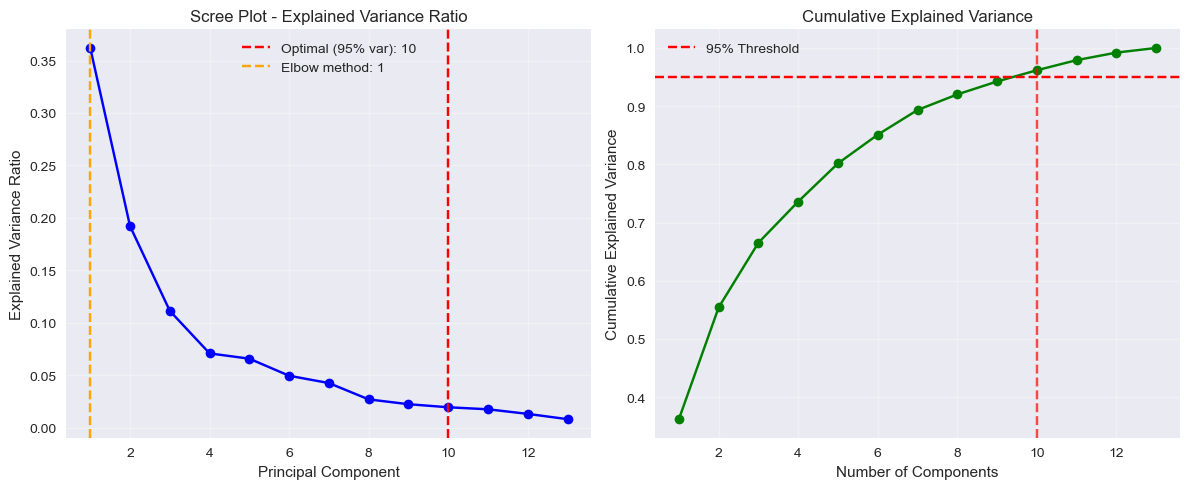

🔍 Component Selection Analysis:
   - 95% variance method: 10 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 3 components
   - Variance at optimal : 96.17%
\n🔧 Applying PCA transformation...
🔍 Component Selection Analysis:
   - 95% variance method: 10 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 3 components
   - Variance at optimal : 96.17%
🔧 PCA transformation completed:
   - Original dimensions      : 13
   - Reduced  dimensions      : 10
   - Compression ratio        : 76.92%
   - Total variance explained : 96.17%
\n📋 Component Analysis:
🔍 DETAILED COMPONENT ANALYSIS
\nPC1:
  Explained Variance: 4.7324
  Explained Variance Ratio: 36.20%
  Top 5 Contributing Features:
    1. flavanoids: 0.4229 (|0.4229|)
    2. total_phenols: 0.3947 (|0.3947|)
    3. od280/od315_of_diluted_wines: 0.3762 (|0.3762|)
    4. proanthocyanins: 0.3134 (|0.3134|)
    5. nonflavanoid_phenols: -0.2985 (|0.2985|)
\nPC2:
  Explained Variance: 2.5111

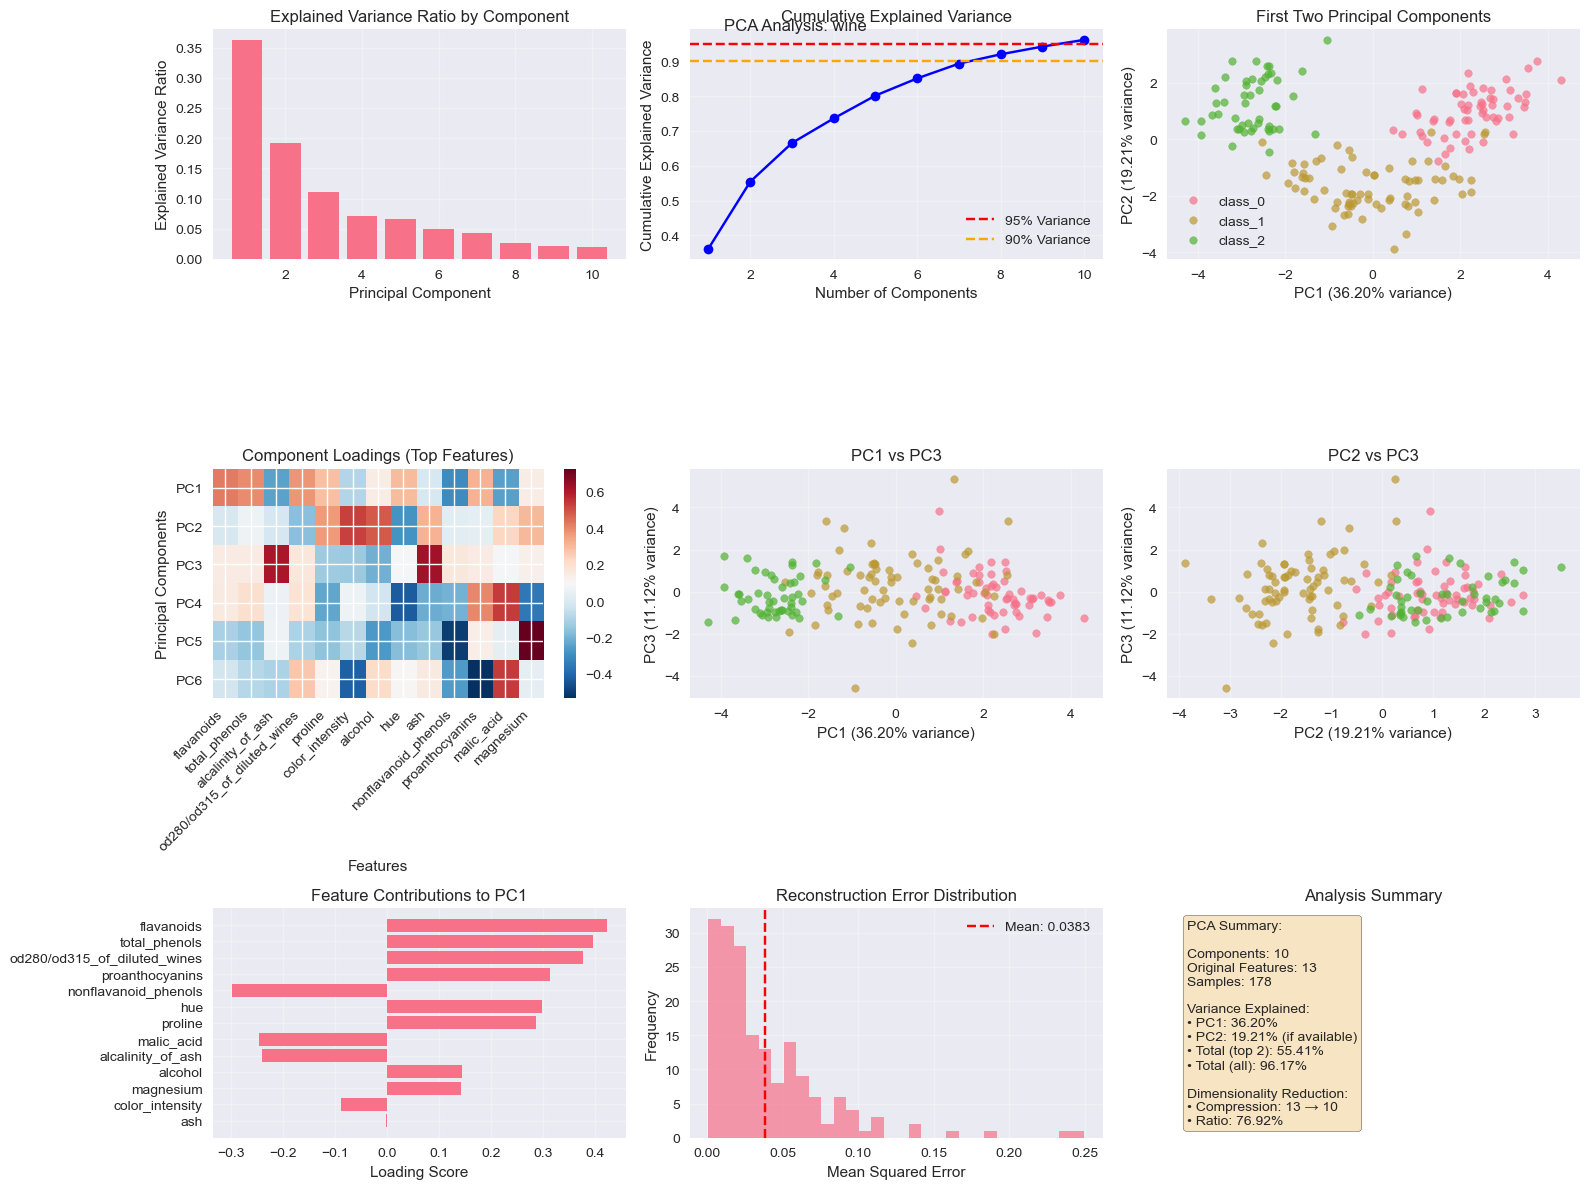

\n✅ Analysis of wine dataset complete!
\n============================================================
📊 ANALYZING DATASET: DIGITS
Data shape: (1797, 64)
Features: 64
Classes: 10
Samples per class: [178 182 177 183 181 182 181 179 174 180]
✅ Data standardized using StandardScaler
📊 Processed data shape: (1797, 64)
\n🔍 Finding optimal number of components...


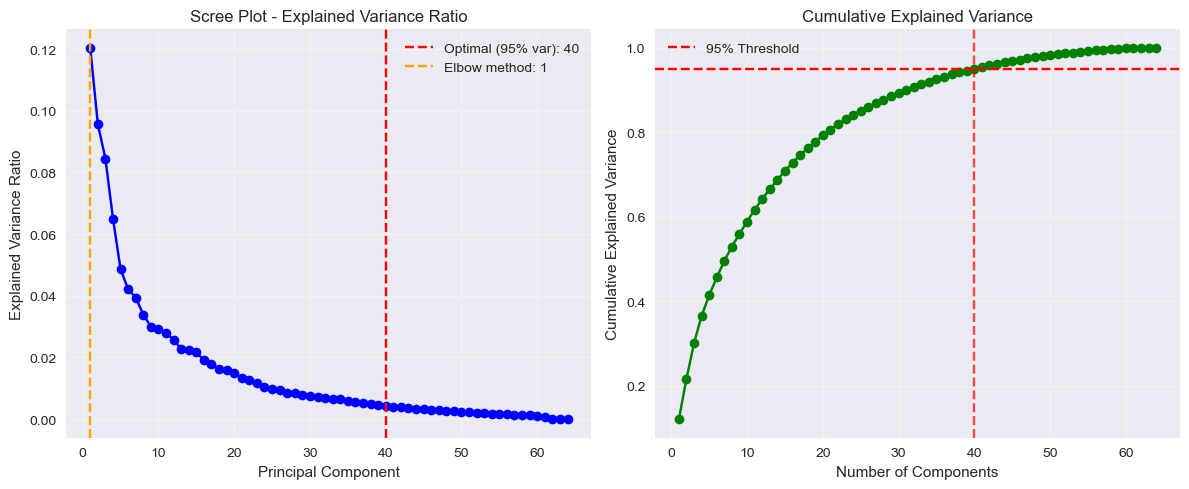

🔍 Component Selection Analysis:
   - 95% variance method: 40 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 17 components
   - Variance at optimal : 95.08%
\n🔧 Applying PCA transformation...
🔍 Component Selection Analysis:
   - 95% variance method: 40 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 17 components
   - Variance at optimal : 95.08%
🔧 PCA transformation completed:
   - Original dimensions      : 64
   - Reduced  dimensions      : 40
   - Compression ratio        : 62.50%
   - Total variance explained : 95.08%
\n📋 Component Analysis:
🔍 DETAILED COMPONENT ANALYSIS
\nPC1:
  Explained Variance: 7.3448
  Explained Variance Ratio: 12.03%
  Top 5 Contributing Features:
    1. pixel_2: 0.2859 (|0.2859|)
    2. pixel_58: 0.2799 (|0.2799|)
    3. pixel_9: 0.2455 (|0.2455|)
    4. pixel_33: -0.2389 (|0.2389|)
    5. pixel_34: -0.2350 (|0.2350|)
\nPC2:
  Explained Variance: 5.8355
  Explained Variance Ratio: 9.56%
  Top 5 Co

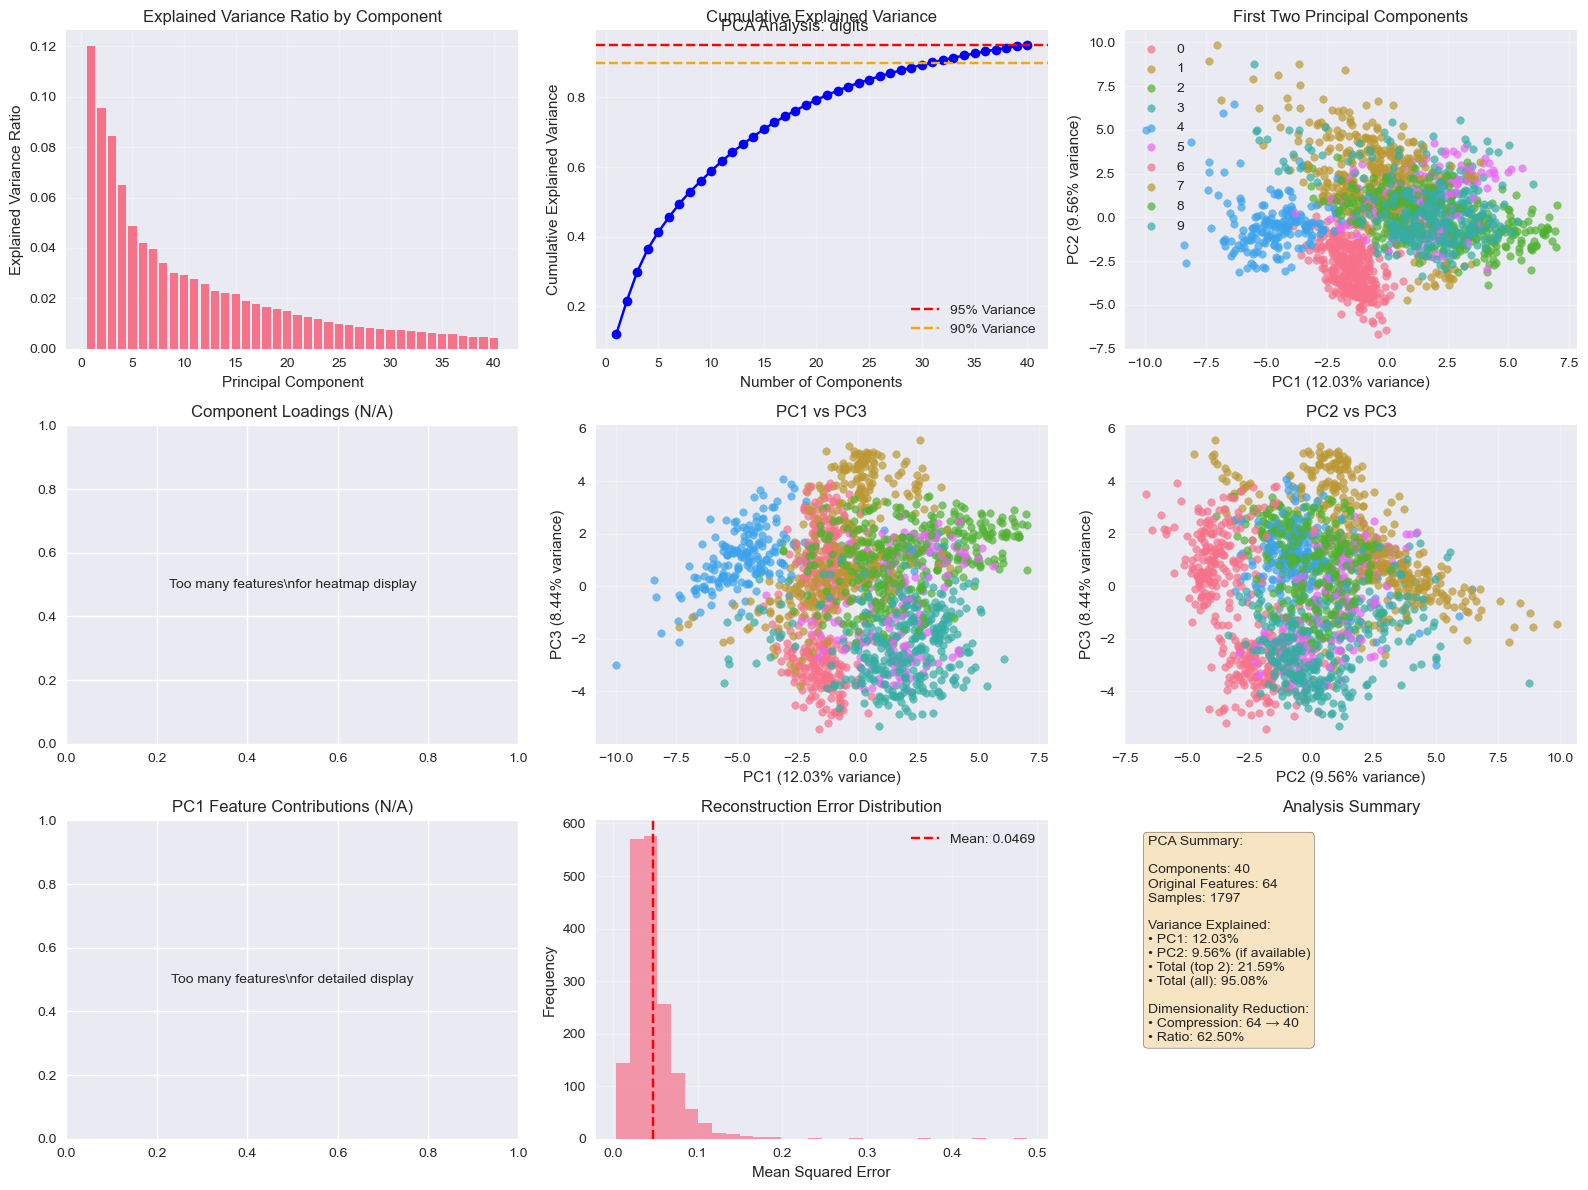

\n✅ Analysis of digits dataset complete!
\n============================================================
📊 ANALYZING DATASET: BREAST_CANCER
Data shape: (569, 30)
Features: 30
Classes: 2
Samples per class: [212 357]
✅ Data standardized using StandardScaler
📊 Processed data shape: (569, 30)
\n🔍 Finding optimal number of components...


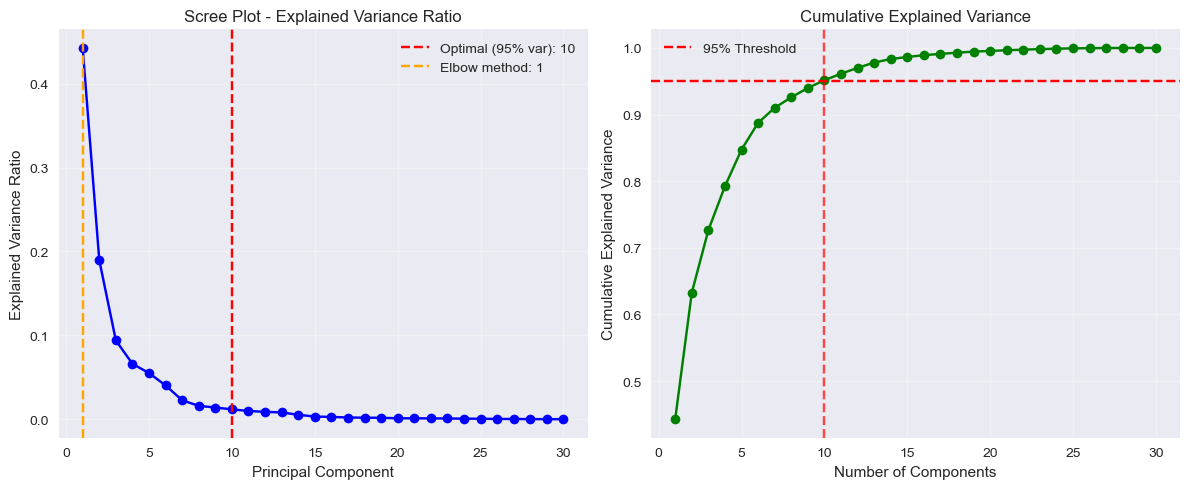

🔍 Component Selection Analysis:
   - 95% variance method: 10 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 6 components
   - Variance at optimal : 95.16%
\n🔧 Applying PCA transformation...
🔍 Component Selection Analysis:
   - 95% variance method: 10 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 6 components
   - Variance at optimal : 95.16%
🔧 PCA transformation completed:
   - Original dimensions      : 30
   - Reduced  dimensions      : 10
   - Compression ratio        : 33.33%
   - Total variance explained : 95.16%
\n📋 Component Analysis:
🔍 DETAILED COMPONENT ANALYSIS
\nPC1:
  Explained Variance: 13.3050
  Explained Variance Ratio: 44.27%
  Top 5 Contributing Features:
    1. mean concave points: 0.2609 (|0.2609|)
    2. mean concavity: 0.2584 (|0.2584|)
    3. worst concave points: 0.2509 (|0.2509|)
    4. mean compactness: 0.2393 (|0.2393|)
    5. worst perimeter: 0.2366 (|0.2366|)
\nPC2:
  Explained Variance: 5.7014
 

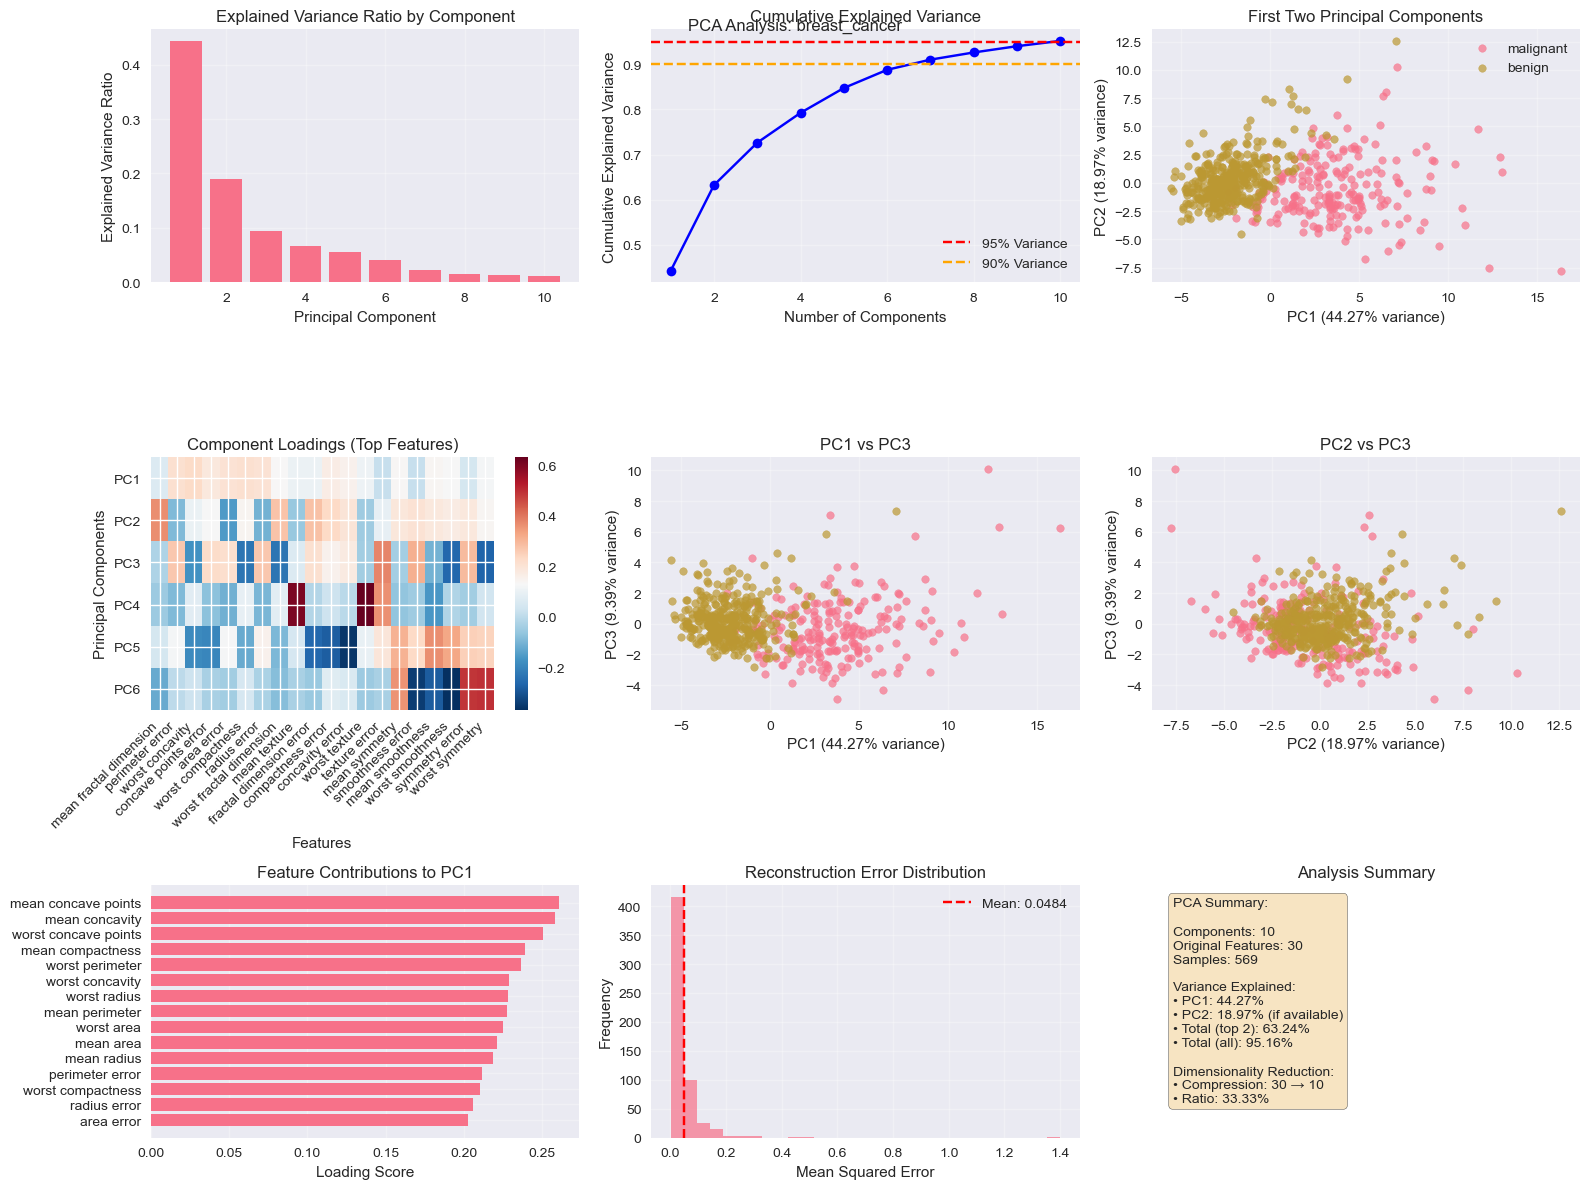

\n✅ Analysis of breast_cancer dataset complete!
\n============================================================
📊 ANALYZING DATASET: SYNTHETIC
Data shape: (1000, 50)
Features: 50
Classes: 2
Samples per class: [499 501]
✅ Data standardized using StandardScaler
📊 Processed data shape: (1000, 50)
\n🔍 Finding optimal number of components...


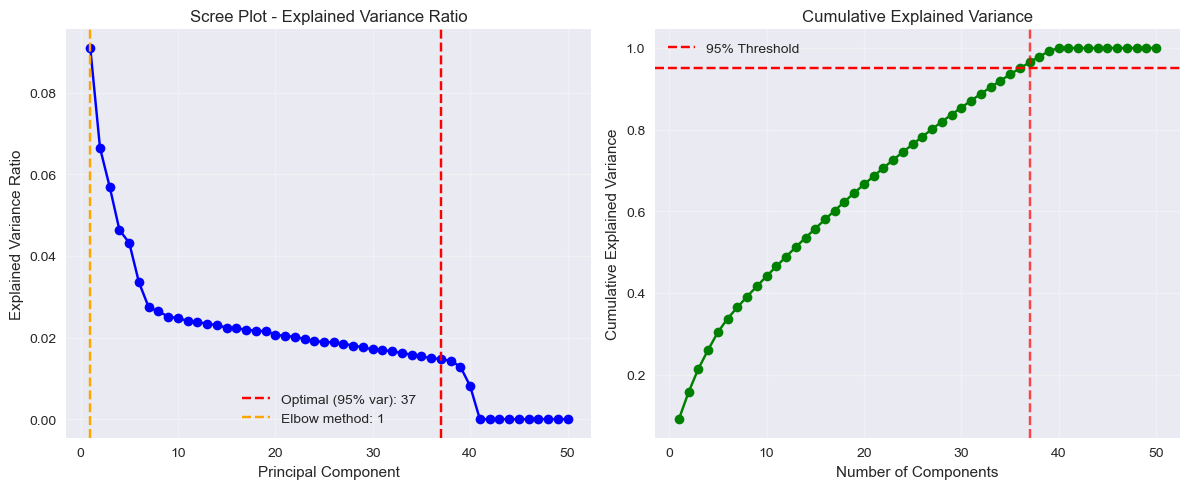

🔍 Component Selection Analysis:
   - 95% variance method: 37 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 22 components
   - Variance at optimal : 96.47%
\n🔧 Applying PCA transformation...
🔍 Component Selection Analysis:
   - 95% variance method: 37 components
   - Elbow method        : 1 components
   - Kaiser criterion    : 22 components
   - Variance at optimal : 96.47%
🔧 PCA transformation completed:
   - Original dimensions      : 50
   - Reduced  dimensions      : 37
   - Compression ratio        : 74.00%
   - Total variance explained : 96.47%
\n📋 Component Analysis:
🔍 DETAILED COMPONENT ANALYSIS
\nPC1:
  Explained Variance: 4.5518
  Explained Variance Ratio: 9.09%
  Top 5 Contributing Features:
    1. feature_13: 0.4456 (|0.4456|)
    2. feature_2: 0.4151 (|0.4151|)
    3. feature_3: 0.3326 (|0.3326|)
    4. feature_21: 0.3232 (|0.3232|)
    5. feature_17: 0.3021 (|0.3021|)
\nPC2:
  Explained Variance: 3.3261
  Explained Variance Ratio: 6.65%
  T

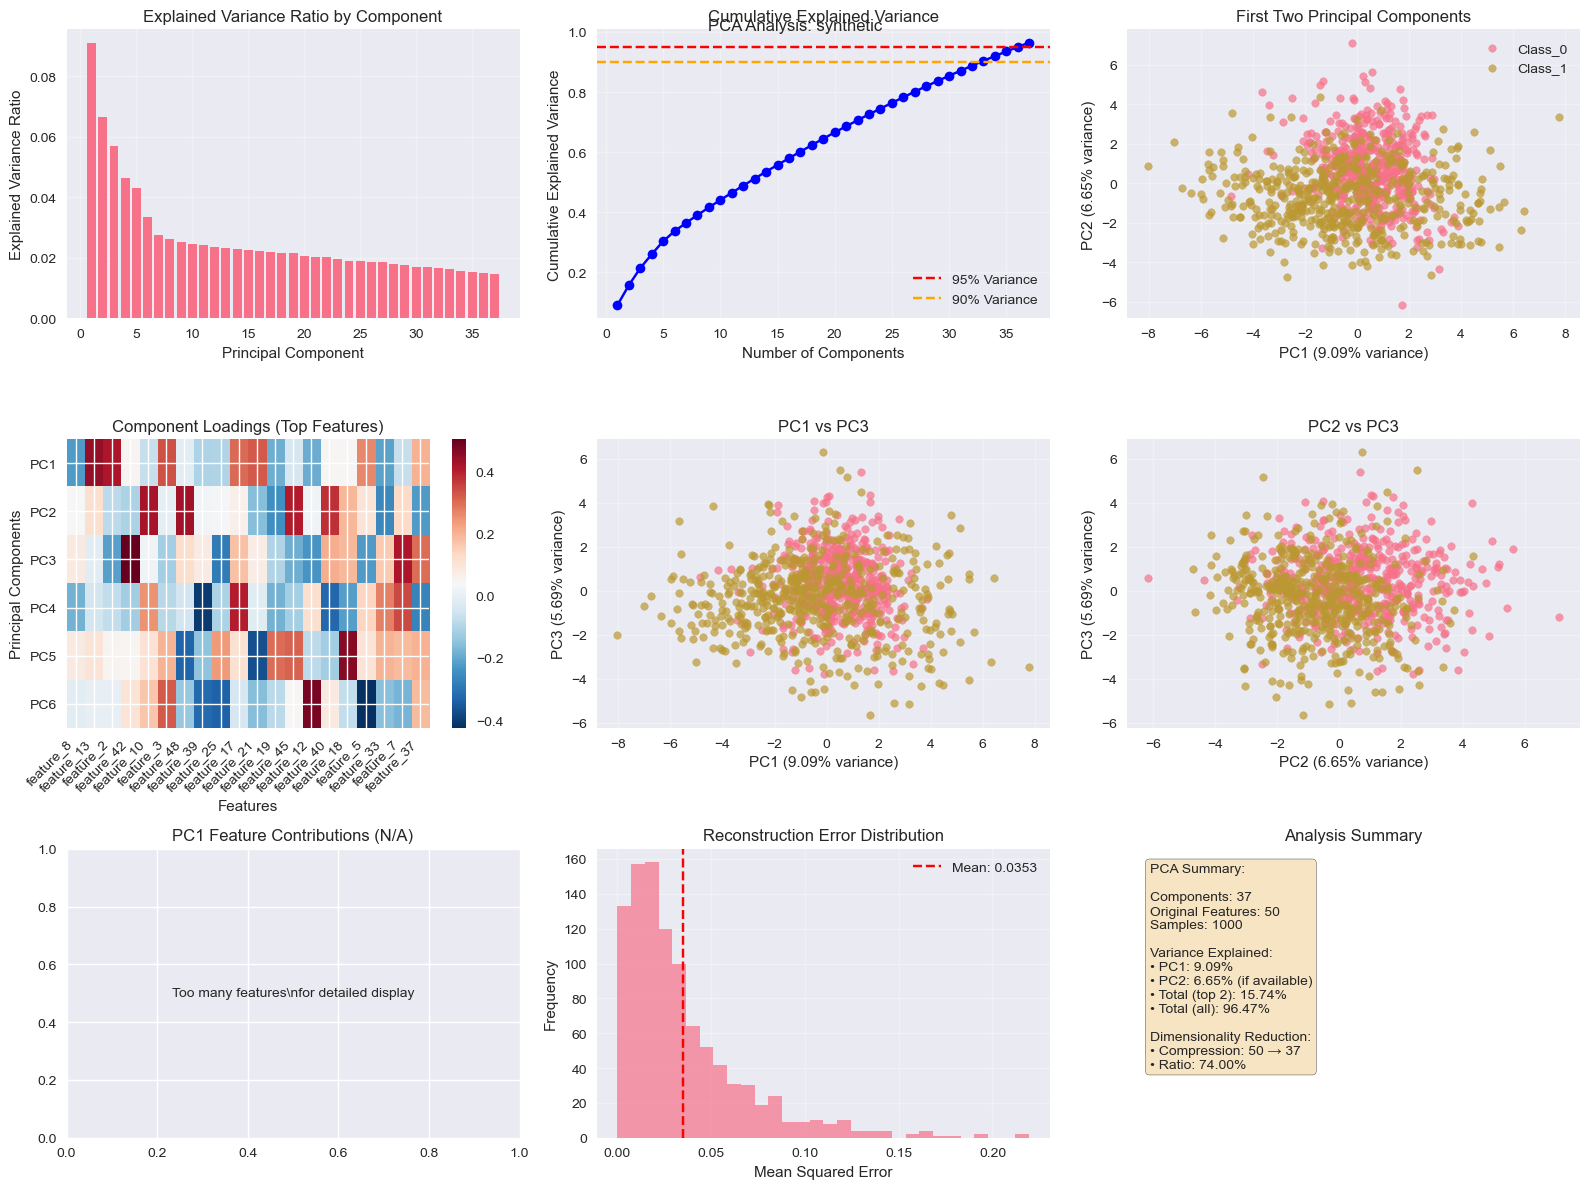

\n✅ Analysis of synthetic dataset complete!
\n🎉 All PCA demonstrations completed successfully!


In [11]:
# Run PCA examples
if __name__ == '__main__':
    # Option 1: Run the quick example
    print("Running quick PCA example...\n")
    quick_pipeline = quick_pca_example()
    
    # Option 2: Run comprehensive demo on various datasets
    print("\nRunning comprehensive PCA demonstration...\n")
    demo_pipeline = demonstrate_pca_pipeline()
    
    # Uncomment to run real-world datasets examples
    # print("\nRunning real-world dataset examples...\n")
    # real_world_results = apply_pca_to_real_datasets()
    
    # Uncomment to run image analysis examples
    # These can be computationally intensive
    # print("\nRunning PCA on image datasets...\n")
    # image_results = apply_pca_to_images()
    
    # Uncomment to run incremental PCA example for large datasets
    # This example demonstrates how to handle datasets too large to fit in memory
    # print("\nRunning incremental PCA example...\n")
    # incremental_results = apply_incremental_pca()